In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
# from sklearn.pipeline import pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
train = pd.read_csv("/content/drive/MyDrive/10Academy/Week4/train.csv",low_memory=False)
store = pd.read_csv("/content/drive/MyDrive/10Academy/Week4/store.csv")
test = pd.read_csv("/content/drive/MyDrive/10Academy/Week4/test.csv")

In [5]:
train_data = train.merge(store, on='Store', how='left')
test_data = test.merge(store, on='Store', how='left')

#### Preprocessing

In [6]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [7]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [8]:
missing_columns = [col for col in test.columns if col not in train.columns]

if missing_columns:
    print("Missing columns in train:", missing_columns)
else:
    print("All test columns are present in train.")

Missing columns in train: ['Id']


- Missing check

In [9]:
train.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0


- #### Extract Features

In [10]:
train['Date'] = pd.to_datetime(train['Date'])

train['Weekday'] = train['Date'].dt.weekday
train['Weekend'] = (train['Weekday'] >= 5).astype(int)
train['Beginning_of_Month'] = (train['Date'].dt.day <= 7).astype(int)
train['Mid_Month'] = ((train['Date'].dt.day > 7) & (train['Date'].dt.day <= 21)).astype(int)
train['End_of_Month'] = (train['Date'].dt.day > 21).astype(int)

In [11]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Weekday,Weekend,Beginning_of_Month,Mid_Month,End_of_Month
0,1,5,2015-07-31,5263,555,1,1,0,1,4,0,0,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1,4,0,0,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,4,0,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,4,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1,4,0,0,0,1


1. **Machine Learning**

### create steps for pipeline

In [12]:
numeric_cols = train.select_dtypes(include="number")
numeric_cols = [col for col in numeric_cols if col != 'Sales']
numeric_cols

['Store',
 'DayOfWeek',
 'Customers',
 'Open',
 'Promo',
 'SchoolHoliday',
 'Weekday',
 'Weekend',
 'Beginning_of_Month',
 'Mid_Month',
 'End_of_Month']

- **Scale features**

In [13]:
scalar = StandardScaler()
scaled_col  = scalar.fit_transform(train[numeric_cols])

## Spliting data for training

In [14]:
X = scaled_col
y = train['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## make Pipeline

In [15]:
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [16]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('regressor', RandomForestRegressor(random_state=42))])

 - **Feature Importance**

In [ ]:
importances = pipeline.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame(importances, index=numeric_cols, columns=["Importance"]).sort_values("Importance", ascending=False)
print(feature_importance_df)

                    Importance
Customers             0.857521
Store                 0.102975
Promo                 0.023737
Weekday               0.005392
DayOfWeek             0.005043
SchoolHoliday         0.001626
End_of_Month          0.001333
Mid_Month             0.001067
Beginning_of_Month    0.000963
Weekend               0.000343
Open                  0.000000


In [ ]:
import joblib
from datetime import datetime

timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
joblib.dump(pipeline, f'sales_prediction_model_{timestamp}.pkl')

['sales_prediction_model_02-01-2025-11-55-10.pkl']

#### Building Model with Deep Learning

In [28]:
store_data = train[train['Store'] == 1].set_index('Date')['Sales']
store_data

,Sales
Date,
2015-07-31,5263
2015-07-30,5020
2015-07-29,4782
2015-07-28,5011
2015-07-27,6102
...,...
2013-01-05,4997
2013-01-04,4486
2013-01-03,4327


In [32]:
# Function to perform the Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

# Check stationarity
test_stationarity(store_data)

ADF Statistic: -4.374783612581194
p-value: 0.00032886553525138343
The time series is stationary.


In [33]:
store_data_diff = store_data.diff().dropna()
test_stationarity(store_data_diff)

ADF Statistic: -11.490966991050025
p-value: 4.737562438832957e-21
The time series is stationary.


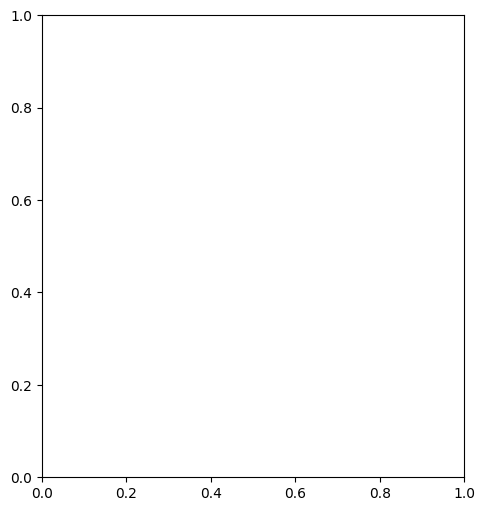

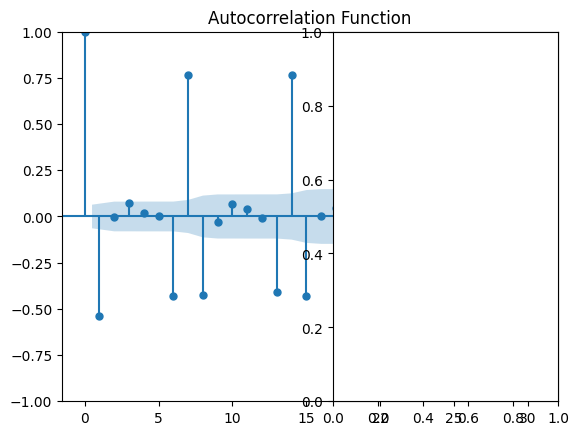

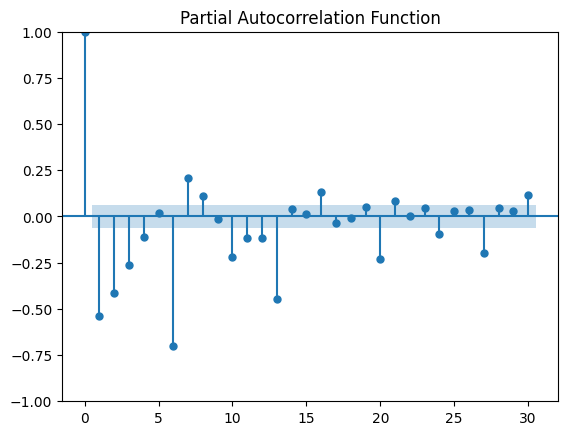

In [39]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2,2)
plot_acf(store_data_diff)
plt.title('Autocorrelation Function')
plt.subplot(1, 2,2)
plot_pacf(store_data_diff)
plt.title('Partial Autocorrelation Function')
plt.show();

In [40]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Define time steps
time_steps = 3
X, y = create_dataset(store_data.values, time_steps)

In [41]:
# Scale the data to the range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Reshape X for LSTM input
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

In [42]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_scaled.shape[1], 1)))
model.add(Dropout(0.2))  # Optional dropout layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# Fit the model
model.fit(X_scaled, y_scaled, epochs=50, batch_size=32)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2068
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1838
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1747
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1763
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1627
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1702
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1500
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1609
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1559
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1553
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1700
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1620
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1510
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1503
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1550
Epoch 16/50
30/30 ━

In [44]:
# Make predictions
predicted_sales = model.predict(X_scaled)

# Inverse transform to get actual sales values
predicted_sales = scaler.inverse_transform(predicted_sales)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


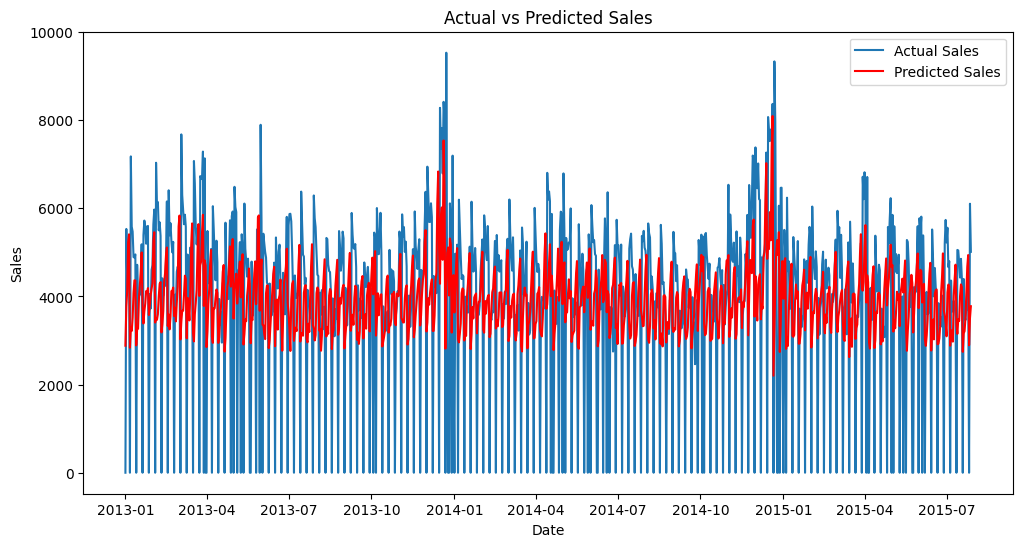

In [45]:
# Plot the actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(store_data.index[time_steps:], store_data.values[time_steps:], label='Actual Sales')
plt.plot(store_data.index[time_steps:], predicted_sales, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()